In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/scaler_clustering.csv')

In [39]:
print(df.head(30))
print(df.shape)

    Unnamed: 0                         company_hash  \
0            0                       atrgxnnt xzaxv   
1            1            qtrxvzwt xzegwgbb rxbxnta   
2            2                        ojzwnvwnxw vx   
3            3                            ngpgutaxv   
4            4                           qxen sqghu   
5            5  yvuuxrj hzbvqqxta bvqptnxzs ucn rna   
6            6                   lubgqsvz wyvot  wg   
7            7                 vwwtznhqt ntwyzgrgsj   
8            8                   utqoxontzn ojontbo   
9            9                                xrbhd   
10          10                      ztfstz ogenfvqt   
11          11                           ngdor ntwy   
12          12           mvqwrvjo wgqugqvnt mvzpxzs   
13          13                            wgszxkvzn   
14          14                               xznhxn   
15          15                               bgsrxd   
16          16                    pnw xzaxv ucn rna   
17        

In [40]:
df.rename(columns={'Unnamed: 0':'ID'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [41]:
df.isnull().sum()

ID                      0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

In [42]:
df_emailcounts=pd.DataFrame(df['email_hash'].value_counts().reset_index())
df_emailcounts.rename(columns={'count':'email_count'},inplace=True)

df_companycounts=pd.DataFrame(df['company_hash'].value_counts().reset_index())
df_companycounts.rename(columns={'count':'company_count'},inplace=True)

df_jobcounts=pd.DataFrame(df['job_position'].value_counts().reset_index())
df_jobcounts.rename(columns={'count':'job_count'},inplace=True)


df=pd.merge(df,df_emailcounts)
df=pd.merge(df,df_companycounts)
df=pd.merge(df,df_jobcounts)

# Dropping duplicate rows
df[['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']].duplicated().value_counts()
df.drop_duplicates(subset=['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year'],inplace=True)
# print(df[['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']].duplicated().value_counts())


# Dropping rows that could have inaccurate data
df.drop(index=df[(df['orgyear']<1000) | (df['orgyear']>df['ctc_updated_year'])].index,inplace=True)
# print(df[(df['orgyear']<1000) | (df['orgyear']>df['ctc_updated_year'])])

# Dropping all NA rows
print('ToDO: Impute the missing data')
df.dropna(axis=0,how='any',inplace=True)

ToDO: Impute the missing data


In [43]:
df.sort_values(['company_count','email_count','ctc_updated_year'],ascending=[False,False,True]).head(20)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,email_count,company_count,job_count
62472,11337,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,Data Scientist,2020.0,8,8337,5368
105685,22427,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,Frontend Engineer,2020.0,8,8337,10417
5409,81153,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Other,2021.0,8,8337,18071
28791,90953,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Backend Engineer,2021.0,8,8337,43554
62473,93126,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Data Scientist,2021.0,8,8337,5368
105686,132837,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Frontend Engineer,2021.0,8,8337,10417
29479,180041,nvnv wgzohrnvzwj otqcxwto,571cb2a38ba9337fd5c19fa53467a02bde1944ac4de786...,2018.0,400000,Backend Engineer,2019.0,6,8337,43554
29530,106804,nvnv wgzohrnvzwj otqcxwto,8648e44737d2ce93d52da116a9aa697c33b8c5da41ed7b...,2016.0,460000,Backend Engineer,2019.0,6,8337,43554
29565,95466,nvnv wgzohrnvzwj otqcxwto,141da2bccc07c268122910ee16542ccf10231d190d6a72...,2018.0,400000,Backend Engineer,2019.0,6,8337,43554
85288,131001,nvnv wgzohrnvzwj otqcxwto,571cb2a38ba9337fd5c19fa53467a02bde1944ac4de786...,2018.0,400000,FullStack Engineer,2019.0,6,8337,24717


# Unsure why there are duplicates of email_hash. Ideally this should be unique to each individual learner. However same value is linked with different job_profiles. For the rest of this analysis, I assume each row is a unique individual.

<ipython-input-44-5c37d4147b92>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(dist_company.index,rotation=90)
<ipython-input-44-5c37d4147b92>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(dist_job.index,rotation=90)


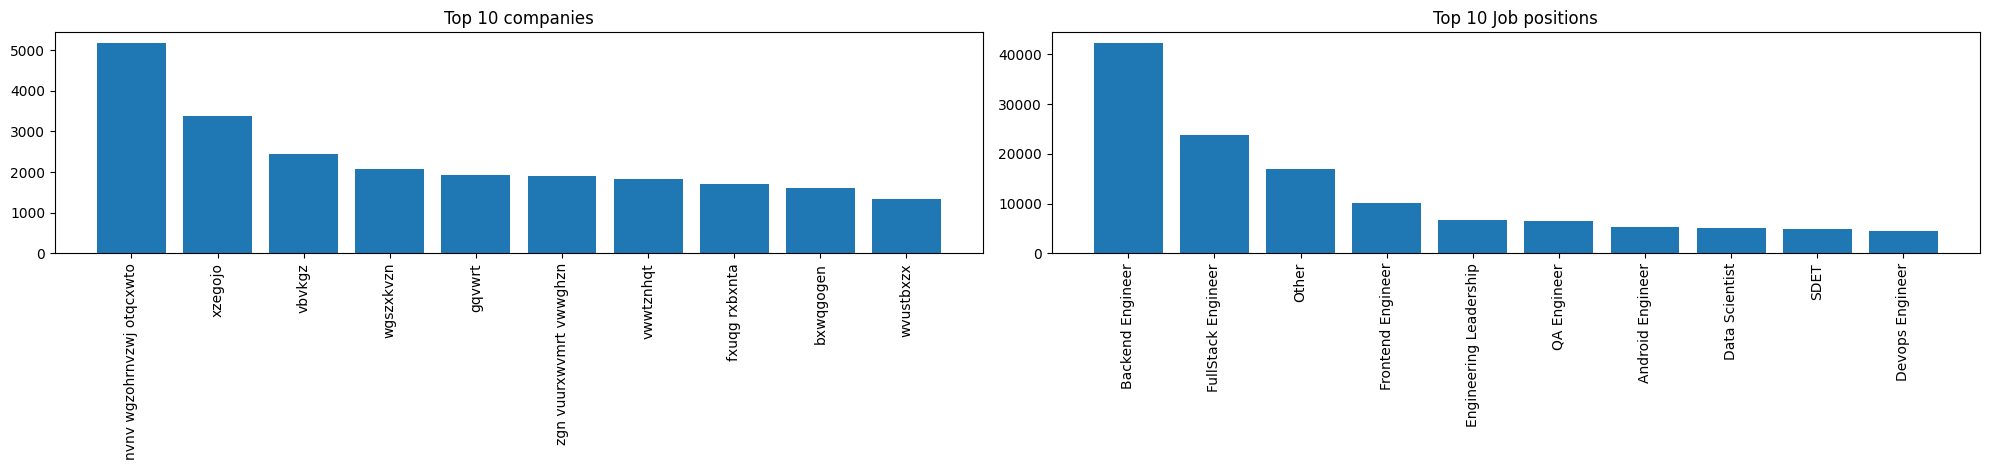

In [44]:
fig,ax=plt.subplots(nrows=1,ncols=2)
plt.rcParams.update({'font.size':10})
fig.set_figwidth(20)

dist_company=df['company_hash'].value_counts().head(10)
dist_job=df['job_position'].value_counts().head(10)

ax[0].bar(dist_company.index,dist_company)
ax[0].set_xticklabels(dist_company.index,rotation=90)
ax[0].set_title('Top 10 companies')

ax[1].bar(dist_job.index,dist_job)
ax[1].set_xticklabels(dist_job.index,rotation=90)
ax[1].set_title('Top 10 Job positions')

plt.tight_layout()

Top repeating email hashes

Text(0.5, 1.0, 'Frequency of occurence of emails')

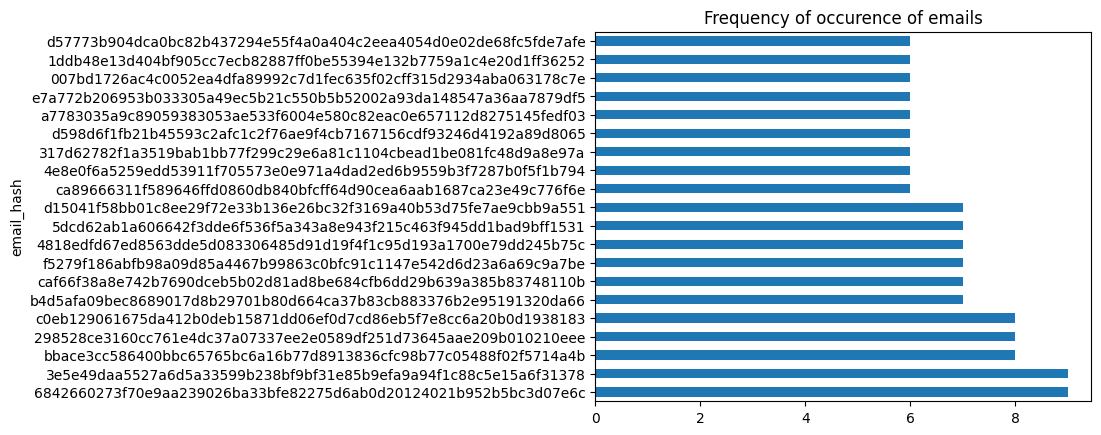

In [45]:
df['email_hash'].value_counts().head(20).plot(kind='barh')
plt.xlabel('')
plt.title('Frequency of occurence of emails')

ToDO

1. what is the typical time for promotion for different roles within and between companies?
2. What is the CTC difference between roles in a company and between companies
3. How did the learners joining scaler change in job role over time?
  **There are corrections needed in orgyear**






# ToDO: Fill missing values by the most frequent value in the **group**

In [46]:
# df.groupby('company_hash')['job_position'].value_counts().head(50)
# df.groupby('company_hash')['job_position'].agg(lambda x: x.value_counts().index[0] if x.nunique()>1 else pd.NA).head(50)

In [47]:
df.isnull().sum()

ID                  0
company_hash        0
email_hash          0
orgyear             0
ctc                 0
job_position        0
ctc_updated_year    0
email_count         0
company_count       0
job_count           0
dtype: int64

# Feature Engineering

In [48]:
df['YoE']=df['ctc_updated_year']-df['orgyear']


df['group_company']=df['company_hash']
df.loc[df['company_count']<100,'group_company']='OTHER'
# df['group_company'].fillna('OTHER')

df['group_job']=df['job_position']
df.loc[df['job_count']<1000,'group_job']='OTHER'
df['group_job'].value_counts()


df['group_YoE']=df['YoE']
df['group_YoE']=(np.floor(df['YoE']/3))+1
df['group_YoE'].value_counts()

df['YoE'].describe()

count    148144.000000
mean          4.943474
std           4.101308
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         119.000000
Name: YoE, dtype: float64

In [57]:
df_desig=df.groupby(['group_company','group_job','group_YoE'])['ctc'].describe()
df_desig.drop(columns=['std','25%','75%'],inplace=True)
df_desig.columns=['count_desig','mean_desig','min_desig','median_desig','max_desig']
df_desig.reset_index(inplace=True)
df=pd.merge(df,df_desig[['group_company','group_job','group_YoE','median_desig']],on=['group_company','group_job','group_YoE'],how='left')

df_class=df.groupby(['group_company','group_job'])['ctc'].describe()
df_class.drop(columns=['std','25%','75%'],inplace=True)
df_class.columns=['count_class','mean_class','min_class','median_class','max_class']
df_class.reset_index(inplace=True)
df=pd.merge(df,df_class[['group_company','group_job','median_class']],on=['group_company','group_job'],how='left')

df_tier=df.groupby('group_company')['ctc'].describe()
df_tier.drop(columns=['std','25%','75%'],inplace=True)
df_tier.columns=['count_tier','mean_tier','min_tier','median_tier','max_tier']
df_tier.reset_index(inplace=True)
df=pd.merge(df,df_tier[['group_company','median_tier']],on='group_company',how='left')


# Designation is based on Company, YoE and dept
df['desig']=3
df.loc[df['ctc']==df['median_desig'],'desig']=2
df.loc[df['ctc']>df['median_desig'],'desig']=1

# Class is based on company, dept
df['class']=3
df.loc[df['ctc']==df['median_class'],'class']=2
df.loc[df['ctc']>df['median_class'],'class']=1

# Tier is based on Company
df['tier']=3
df.loc[df['ctc']==df['median_tier'],'tier']=2
df.loc[df['ctc']>df['median_tier'],'tier']=1



KeyError: "['median_design'] not in index"

In [61]:
# Designation is based on Company, YoE and dept
df['desig']=3
df.loc[df['ctc']==df['median_desig'],'desig']=2
df.loc[df['ctc']>df['median_desig'],'desig']=1

# Class is based on company, dept
df['class']=3
df.loc[df['ctc']==df['median_class'],'class']=2
df.loc[df['ctc']>df['median_class'],'class']=1

# Tier is based on Company
df['tier']=3
df.loc[df['ctc']==df['median_tier'],'tier']=2
df.loc[df['ctc']>df['median_tier'],'tier']=1

df.head()

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,email_count,company_count,job_count,YoE,group_company,group_job,group_YoE,median_desig,median_class,median_tier,desig,class,tier
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0,2,9,18071,4.0,OTHER,Other,2.0,650000.0,680000.0,950000.0,1,1,1
1,70864,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014.0,1070000,Other,2018.0,1,9,18071,4.0,OTHER,Other,2.0,650000.0,680000.0,950000.0,1,1,1
2,336,xzegojo,060332879b510325ae496d07bc96acda88024cd57c56c1...,2017.0,808000,Other,2020.0,3,5381,18071,3.0,xzegojo,Other,2.0,450000.0,430000.0,490000.0,1,1,1
3,201584,xzegojo,060332879b510325ae496d07bc96acda88024cd57c56c1...,2017.0,550000,Other,2021.0,3,5381,18071,4.0,xzegojo,Other,2.0,450000.0,430000.0,490000.0,1,1,1
4,464,xzegojo,7fb33e269150b9a2e14b51ff905fa461e7000859543d1a...,2016.0,500000,Other,2021.0,2,5381,18071,5.0,xzegojo,Other,2.0,450000.0,430000.0,490000.0,1,1,1


In [60]:
# df['email_hash'].value_counts()

email_hash
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c    9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378    9
bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    8
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee    8
c0eb129061675da412b0deb15871dd06ef0d7cd86eb5f7e8cc6a20b0d1938183    8
                                                                   ..
56d80cd4e7516b3023b3bdb6db99371567d58678283879ede1f95f31aa1658fa    1
1bd0a613b13f4f0dc8fe8a49947267073fd178c49f030832e9d9721c0b3cb714    1
deac0c9762ea01a5482f579465a2d8e9431722040def38c2e725e8cdeaedc6b6    1
b0b4f9464e2186ae0c1393799b11945d6b5c2d1d5374d715b976794fdefd2a76    1
0ec7358edc76aa85d4aead472592c1cbb28b4ab15ec680c1254edbb2186eb7f9    1
Name: count, Length: 128666, dtype: int64

In [62]:
df.to_pickle('/content/gdrive/My Drive/Colab Notebooks/clustering_pkl.pkl')

In [ ]:
# plt.scatter(df['ID'],df['orgyear'])
# plt.yscale('log')